In [1]:
# Initialize to load modules
%load_ext autoreload
%autoreload 2

#For this project please set to False, since database and rag are already prepared.
#Enable SetupDBRag = True (This will allow to create new Database/Rag).
SetupDBRag = False
#To display the state at each step, default set to False unless need to debug
DebugLangGraph = False

In [2]:
# Initialize environment
import sys
import os
import importlib


# Add the parent directory to sys.path to resolve local imports
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # If in Colab, use the Google Drive path
    # Modify this path to point to the directory containing your 'controller' directory in Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    parent_dir = '/content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner' # <--- UPDATE THIS PATH
    print(f"Running in Google Colab. Using parent_dir: {parent_dir}")
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    !pip install -r '{parent_dir}/requirements.txt'
else:
    # If not in Colab, use the parent directory of the current working directory
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    print(f"Not running in Google Colab. Using parent_dir: {parent_dir}")
    #!python -m venv python310
    #!myenv\Scripts\python -m pip install ipykernel
    #!myenv\Scripts\python -m ipykernel install --user --name=python310 --display-name "Python (python 3.10.18 with requirements)"
    !python310\Scripts\python -m pip install -r C:\Users\thunaung\personal\education\AI\Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025\Week13\ai_prototype_project\requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Google Colab. Using parent_dir: /content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner


Test LangGraph

Building travel planner graph with LLM router...
Travel planner graph with LLM router built successfully.

--- Invoking routed graph with input: Register family members to SQL  ---

--- Expecting SQL_AGENT ---
I’m 42—into museums and food. My wife is 40, she likes the beach and shopping. Our son is 12, loves video games and drawing. My daughter is 10, like to play at beach and love animals.
Registered 4 family members.

--- Invoking routed graph with input: Upload PDF/HTML to RAG ---

--- Expecting RAG_AGENT ---
Please ingest the TripAdvisor URL https://www.klook.com/en-SG/blog/cheapest-holidays-from-singapore/
✅ Ingested 1 source into RAG index.

--- Invoking routed graph with input: Plan a family trip  ---

--- Expecting TRAVEL_PLANNER ---
Plan a family trip
✅ One family-friendly destination related to the beach is **Desaru Coast in Johor, Malaysia**. This laid-back coastal town is perfect for families looking for a beach getaway. It offers a variety of activities, including the **Ad

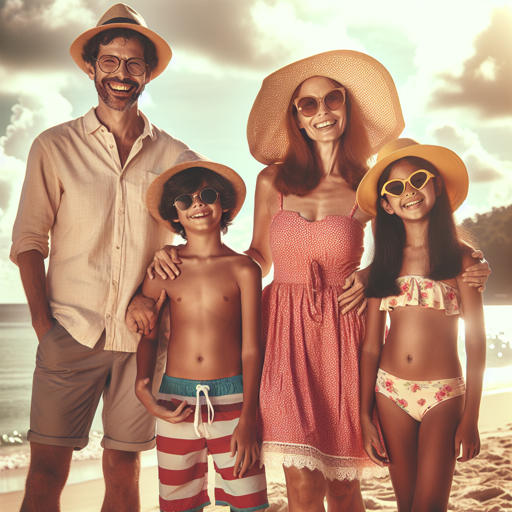


--- Invoking routed graph with input: How is the weather there? ---

--- Expecting WEATHER_INFO ---
How is the weather there?
✅  Partly cloudy, 24.3°C


In [5]:
import re
import replicate
import numpy as np
from typing import Optional, List, Dict, Any, Literal
from pydantic import BaseModel,Field
from sentence_transformers import SentenceTransformer, util

from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_openai import OpenAIEmbeddings, ChatOpenAI # Import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate # Import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser # Import StrOutputParser
from openai import OpenAI # Import the openai library
import json # Import json

# Assuming these imports are necessary and the files exist in the mounted drive
from controller.controller import  load_state, merge_state, save_state, build_travel_planner_graph_with_router
from controller.shared_types import HybridState


# Test the travel planner graph with the LLM router
print("Building travel planner graph with LLM router...")
try:
    travel_planner_graph_routed = build_travel_planner_graph_with_router()
    print("Travel planner graph with LLM router built successfully.")

    # --- Test with different inputs ---


    # Test case 1: Register family members to SQL
    print(f"\n--- Invoking routed graph with input: Register family members to SQL  ---")
    print(f"\n--- Expecting SQL_AGENT ---")
    input = "I’m 42—into museums and food. My wife is 40, she likes the beach and shopping. Our son is 12, loves video games and drawing. My daughter is 10, like to play at beach and love animals."
    print(input)
    try:
        state = load_state()
        state = merge_state(state, input)
        #plan = HybridState(input=input)
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during SQL_AGENT invocation: {e}")

    # Test case 2: Data upload to RAG
    print(f"\n--- Invoking routed graph with input: Upload PDF/HTML to RAG ---")
    print(f"\n--- Expecting RAG_AGENT ---")
    #input = "Please ingest this PDF at /content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner/travelguide/Americas_compressed.pdf and the TripAdvisor URL https://www.klook.com/en-SG/blog/cheapest-holidays-from-singapore/"
    input = "Please ingest the TripAdvisor URL https://www.klook.com/en-SG/blog/cheapest-holidays-from-singapore/"
    print(input)
    try:
        state = load_state()
        state = merge_state(state, input)
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during RAG_AGENT invocation: {e}")


    # Test case 3: Plan Trip
    print(f"\n--- Invoking routed graph with input: Plan a family trip  ---")
    print(f"\n--- Expecting TRAVEL_PLANNER ---")
    input = "Plan a family trip"
    print(input)
    try:

        state = load_state()
        state = merge_state(state, input)
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during TRAVEL_PLANNER invocation: {e}")


    # Test case 4: Trigger photo diea
    print(f"\n--- Invoking routed graph with input: Where can I take good photo there? ---")
    print(f"\n--- Expecting PHOTO_MEMORY ---")
    input =  "Where can I take good photo there?"
    print(input)
    try:
        state = load_state()
        state = merge_state(state,input)
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during PHOTO_MEMORY invocation: {e}")

    # Test case 5: Weather
    print(f"\n--- Invoking routed graph with input: How is the weather there? ---")
    print(f"\n--- Expecting WEATHER_INFO ---")
    input =  "How is the weather there?"
    print(input)
    try:
        state = load_state()
        state = merge_state(state, input )
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during WEATHER_INFO invocation: {e}")


except NameError as e:
    print(f"\nError: {e}.")
except Exception as e:
    print(f"\nAn error occurred during graph building or invocation: {e}")

/tmp/ipython-input-4-2720290842.py:29: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(),       # uses Gradio’s built-in history management
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:322: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bbe87b28dc86fd4e7d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Registered 4 family members.
✅ Ingested 1 source into RAG index.
✅ Based on the documents, a family-friendly destination related to the beach is **Krabi** in Thailand. It offers a range of activities suitable for families, including thrilling rock climbing expeditions at Railay Beach, island hopping, and exploring the stunning limestone cliffs and hidden lagoons of Ao Phang Nga National Park by kayak. These activities provide a mix of adventure and natural beauty, making Krabi a great choice for a family beach getaway.


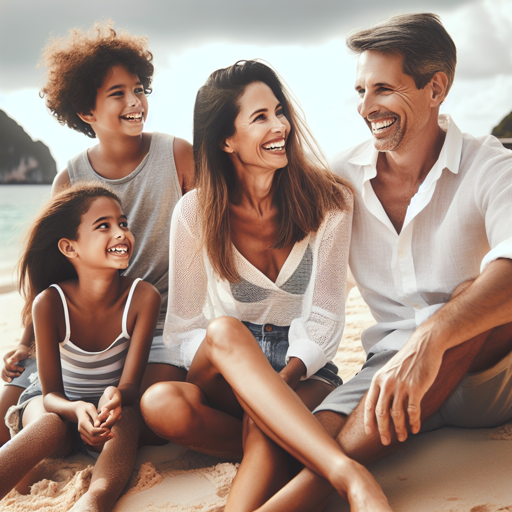

✅  Partly cloudy, 30.2°C
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bbe87b28dc86fd4e7d.gradio.live


In [4]:
import gradio as gr
import json
from controller.controller import load_state, merge_state, save_state
from controller.shared_types import HybridState

def chat_interface(message, history):
    # 1) Load & merge conversation state
    state = load_state()
    state = merge_state(state, message)

    # 2) Run your LangGraph
    try:
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)
        save_state(state)
        bot_reply = state.output or "…"
    except Exception as e:
        bot_reply = f"Error: {e}"

    # 3) Return ONLY the assistant’s content
    return bot_reply

# Check if travel_planner_graph_routed is defined before creating the interface
if 'travel_planner_graph_routed' in globals():
    demo = gr.ChatInterface(
        fn=chat_interface,
        title="Family Travel Planner",
        description="Ask me to plan your family trip!",
        chatbot=gr.Chatbot(),       # uses Gradio’s built-in history management
        textbox=gr.Textbox(placeholder="Type your message…")
    )
    demo.launch(debug=True)
else:
    print("Error: travel_planner_graph_routed is not defined. Please run the cell to build the graph first.")